In [157]:
import numpy as np 
import pandas as pd 
import nltk as nlp

In [158]:
import os

In [159]:
data = pd.read_csv("small_train.csv")

In [160]:
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\r\n{\r\n ...,php api file-get-contents


In [161]:
print(data.Title[1][:500], "...")
print("\ntotal length", len(data.Title[1]))

How can I prevent firefox from closing when I press ctrl-w ...

total length 58


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
Id       10000 non-null int64
Title    10000 non-null object
Body     10000 non-null object
Tags     10000 non-null object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [163]:
import re
data.Title = data.Title.apply(lambda x: re.sub("(\W)", " ", x))

In [164]:
tokenizer = nlp.WordPunctTokenizer()
data["word_count"] = data.Title.apply(lambda x: len(tokenizer.tokenize(x)))
data[["word_count", "Title"]].head()

,word_count,Title
0,13,How to check if an uploaded file is an image w...
1,12,How can I prevent firefox from closing when I ...
2,7,R Error Invalid type list for variable
3,9,How do I replace special characters in a URL
4,6,How to modify whois contact details


In [165]:
freq = pd.Series(" ".join(data.Title).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

to      3119
in      2592
a       2253
How     1477
the     1385
of      1174
with    1070
and     1018
for      867
on       824
dtype: int64
intersection       1
Feedback           1
XSLX               1
COCOS2D            1
BarChart           1
Visibility         1
bapi_po_create1    1
Returns            1
Entire             1
Fade               1
dtype: int64


In [166]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/learny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [167]:
lemma = nlp.WordNetLemmatizer()
data.Title = data.Title.apply(lambda x: lemma.lemmatize(x))

In [168]:
data.Title = data.Title.apply(lambda x: x.lower())

In [169]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [170]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/learny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

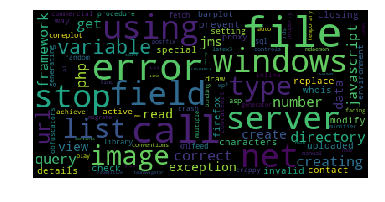

In [171]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='black',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(data.Title))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(data.Title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"doesn't", 'herself', 'hadn', 'as', 'each', 'some', "mustn't", 'shouldn', 'his', 'off', 'most', 'not', 'few', 'isn', 'above', 'she', 'don', 'or', 'needn', 'o', "haven't", 'when', 'was', 'been', 'about', 'here', 'hasn', 'such', 'to', 'whom', "won't", 'will', 'theirs', 'who', 'while', 'onc...lf', 'in', 's', "couldn't", 'yourself', 'more', 'both', 'weren', 'i', 'we', 'why', 'doesn', "she's"},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [173]:
doc = pd.Series(data.Title[500])
doc_vector = tf_idf.transform(doc)

In [174]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

In [175]:
# now print the results
print("Keywords in Title:")
print(doc[0][:10000])

Keywords in Title:
streaming sax xml processing on iphone


In [176]:
print("Keywords in Title:")
for k in keywords:
    print(k,keywords[k])

Keywords in Title:
processing iphone 0.513
sax 0.476
streaming 0.421
processing 0.398
iphone 0.3


In [177]:
print(data.Body[1][:500], "...")
print("\ntotal length", len(data.Body[1]))

<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?</p>

<p>Rene</p>
 ...

total length 363


In [178]:
data.Body = data.Body.apply(lambda x: re.sub("(\W)", " ", x))

In [179]:
tokenizer = nlp.WordPunctTokenizer()
data["word_count"] = data.Body.apply(lambda x: len(tokenizer.tokenize(x)))
data[["word_count", "Body"]].head()

,word_count,Body
0,83,p I d like to check if an uploaded file is an...
1,71,p In my favorite editor vim I regularly us...
2,3161,p I am import matlab file and construct a dat...
3,115,p This is probably very simple but I simply ...
4,148,pre code function modify mco...


In [180]:
freq = pd.Series(" ".join(data.Body).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

p       82119
the     48956
I       39324
to      35505
code    34428
gt      31392
a       31339
lt      27851
is      18499
pre     18300
dtype: int64
filetypes                 1
xdmcp                     1
C01137_1                  1
Slackware                 1
openSUSE                  1
ServiceControllerProxy    1
yrange                    1
Employer                  1
sethostname               1
suitably                  1
dtype: int64


In [181]:
lemma = nlp.WordNetLemmatizer()
data.Body = data.Body.apply(lambda x: lemma.lemmatize(x))

In [182]:
data.Body = data.Body.apply(lambda x: x.lower())

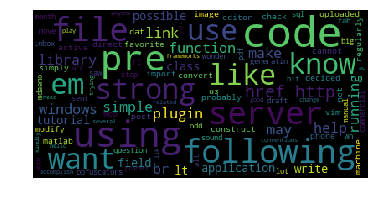

In [183]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='black',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(data.Body))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("word2.png", dpi=900)

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(data.Body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"doesn't", 'herself', 'hadn', 'as', 'each', 'some', "mustn't", 'shouldn', 'his', 'off', 'most', 'not', 'few', 'isn', 'above', 'she', 'don', 'or', 'needn', 'o', "haven't", 'when', 'was', 'been', 'about', 'here', 'hasn', 'such', 'to', 'whom', "won't", 'will', 'theirs', 'who', 'while', 'onc...lf', 'in', 's', "couldn't", 'yourself', 'more', 'both', 'weren', 'i', 'we', 'why', 'doesn', "she's"},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [185]:
doc = pd.Series(data.Body[500])
doc_vector = tf_idf.transform(doc)

In [186]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
keywords1=extract_topn_from_vector(feature_names,sorted_items,5)

In [187]:
print("Keywords in Body:")
print(doc[0][:10000])

Keywords in Body:
 p nsxmlparser allows sax parsing of either an nsdata block or from a url source   p      p the problem is that both these methods require the entire xml source to be known before parsing begins   p      p suppose i have a stream of xml data  say a sequence of nsdata objects  and i want to process the stream using nsxmlparser or another cocoa class  how can i do this without needing to have the whole document to begin with   p   


In [188]:
print("Keywords in Body:")
for m in keywords1:
    print(m,keywords1[m])

Keywords in Body:
nsdata 0.419
parsing 0.359
stream 0.323
source 0.241
xml 0.24


In [189]:
print(data.Tags[1][:500], "...")
print("\ntotal length", len(data.Tags[1]))

firefox ...

total length 7


In [190]:
data.Tags = data.Tags.apply(lambda x: re.sub("(\W)", " ", x))

In [191]:
freq = pd.Series(" ".join(data.Tags).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

c             1565
net            960
java           753
php            726
android        699
jquery         654
javascript     651
asp            544
sql            534
windows        477
dtype: int64
revert           1
effect           1
cin              1
commandbutton    1
vexing           1
cars             1
xstring          1
glut             1
nicedit          1
backups          1
dtype: int64


In [192]:
lemma = nlp.WordNetLemmatizer()
data.Tags = data.Tags.apply(lambda x: lemma.lemmatize(x))

In [193]:
data.Tags = data.Tags.apply(lambda x: x.lower())

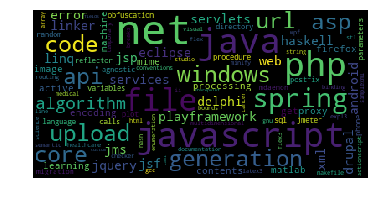

In [194]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='black',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(data.Tags))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("word3.png", dpi=900)

In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(data.Tags)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"doesn't", 'herself', 'hadn', 'as', 'each', 'some', "mustn't", 'shouldn', 'his', 'off', 'most', 'not', 'few', 'isn', 'above', 'she', 'don', 'or', 'needn', 'o', "haven't", 'when', 'was', 'been', 'about', 'here', 'hasn', 'such', 'to', 'whom', "won't", 'will', 'theirs', 'who', 'while', 'onc...lf', 'in', 's', "couldn't", 'yourself', 'more', 'both', 'weren', 'i', 'we', 'why', 'doesn', "she's"},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [196]:
doc = pd.Series(data.Tags[500])
doc_vector = tf_idf.transform(doc)

In [197]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
keywords2=extract_topn_from_vector(feature_names,sorted_items,5)

In [198]:
print("Keywords in Tags:")
print(doc[0][:10000])

Keywords in Tags:
iphone xml cocoa streaming sax


In [199]:
print("Keywords in Tags:")
for n in keywords2:
    print(n,keywords2[n])

Keywords in Tags:
xml cocoa 0.427
sax 0.427
iphone xml cocoa 0.427
iphone xml 0.403
streaming 0.338


In [200]:
print("Total keywords in the whole training data")
for k in keywords:
    print(k,keywords[k])
for m in keywords1:
    print(m,keywords1[m])
for n in keywords2:
    print(n,keywords2[n])

Total keywords in the whole training data
processing iphone 0.513
sax 0.476
streaming 0.421
processing 0.398
iphone 0.3
nsdata 0.419
parsing 0.359
stream 0.323
source 0.241
xml 0.24
xml cocoa 0.427
sax 0.427
iphone xml cocoa 0.427
iphone xml 0.403
streaming 0.338


In [201]:
#Testing data

In [202]:
test_data = pd.read_csv("small_test.csv")

In [203]:
test_data.head()

,Id,Title,Body
0,6034196,Getting rid of site-specific hotkeys,<p>How do I disable site-specific hotkeys if (...
1,6034197,Nodes inside Cisco VPN. Incoming SSH requests ...,<p>I've a gateway-to-gateway VPN setup between...
2,6034198,Remove old vCenter servers from VMWare vSphere...,<p>After changing our vCenter servers recently...
3,6034199,Replace <span> element with var containing html,"<p>I have a variable i lifted the contents of,..."
4,6034200,Will PHP included html content affect my seo?,<p>Today i purchase a small CMS system. With t...


In [204]:
print(test_data.Title[1][:500], "...")
print("\ntotal length", len(test_data.Title[1]))

Nodes inside Cisco VPN. Incoming SSH requests allowed. But can't initiate an outbound SSH ...

total length 89


In [205]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
Id       3000 non-null int64
Title    3000 non-null object
Body     3000 non-null object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [206]:
test_data.Title = test_data.Title.apply(lambda x: re.sub("(\W)", " ", x))

In [207]:
tokenizer = nlp.WordPunctTokenizer()
test_data["word_count"] = test_data.Title.apply(lambda x: len(tokenizer.tokenize(x)))
test_data[["word_count", "Title"]].head()

,word_count,Title
0,6,Getting rid of site specific hotkeys
1,15,Nodes inside Cisco VPN Incoming SSH requests ...
2,10,Remove old vCenter servers from VMWare vSphere...
3,7,Replace span element with var containing html
4,8,Will PHP included html content affect my seo


In [208]:
freq = pd.Series(" ".join(test_data.Title).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

to      929
a       775
in      760
the     426
How     425
of      373
with    328
and     326
on      277
for     245
dtype: int64
offline         1
digital         1
GRUB            1
dbproj          1
Machine         1
Unstructured    1
CoreData        1
invite          1
contend         1
Keyboard        1
dtype: int64


In [209]:
lemma = nlp.WordNetLemmatizer()
test_data.Title = test_data.Title.apply(lambda x: lemma.lemmatize(x))

In [210]:
test_data.Title = test_data.Title.apply(lambda x: x.lower())

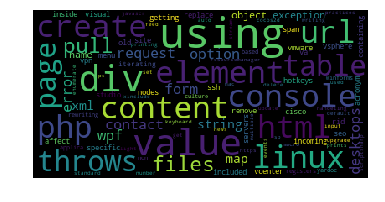

In [211]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='black',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(test_data.Title))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("test_word1.png", dpi=900)

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(test_data.Title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"doesn't", 'herself', 'hadn', 'as', 'each', 'some', "mustn't", 'shouldn', 'his', 'off', 'most', 'not', 'few', 'isn', 'above', 'she', 'don', 'or', 'needn', 'o', "haven't", 'when', 'was', 'been', 'about', 'here', 'hasn', 'such', 'to', 'whom', "won't", 'will', 'theirs', 'who', 'while', 'onc...lf', 'in', 's', "couldn't", 'yourself', 'more', 'both', 'weren', 'i', 'we', 'why', 'doesn', "she's"},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [213]:
doc = pd.Series(test_data.Title[500])
doc_vector = tf_idf.transform(doc)

In [214]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
test_keywords=extract_topn_from_vector(feature_names,sorted_items,5)

In [215]:
print("Keywords in Title - test:")
print(doc[0][:10000])

Keywords in Title - test:
hard symlinks and alternate data streams


In [226]:
print("Keywords in Title - Test:")
for l in test_keywords:
    print(l,test_keywords[l])

Keywords in Title - Test:
streams 0.588
alternate 0.559
hard 0.482
data 0.331


In [217]:
print(test_data.Body[1][:500], "...")
print("\ntotal length", len(test_data.Body[1]))

<p>I've a gateway-to-gateway VPN setup between my Linksys RV042 router and a Cisco VPN. </p>

<p>I am able to SSH into any of the machine inside the VPN from my network. But none of the machines inside the VPN can initiate an SSH into my network. It seems they've blocked even all ping requests to my network gateway.</p>

<p>This is the requirement: I have scripts that SSH into the machines inside the VPN and run a long mysql query. The query generates an output to a file. The time that these ...

total length 903


In [218]:
test_data.Body = test_data.Body.apply(lambda x: re.sub("(\W)", " ", x))

In [219]:
tokenizer = nlp.WordPunctTokenizer()
test_data["word_count"] = test_data.Body.apply(lambda x: len(tokenizer.tokenize(x)))
test_data[["word_count", "Title"]].head()

,word_count,Title
0,107,getting rid of site specific hotkeys
1,173,nodes inside cisco vpn incoming ssh requests ...
2,42,remove old vcenter servers from vmware vsphere...
3,101,replace span element with var containing html
4,166,will php included html content affect my seo


In [220]:
freq = pd.Series(" ".join(test_data.Body).split()).value_counts()
print(freq.head(10))
print(freq.tail(10))

p       24247
the     14730
I       11759
to      10569
code    10161
a        9760
gt       9189
lt       8288
is       5562
and      5488
dtype: int64
hasChildNodes     1
Strongly          1
153               1
eOpts             1
864               1
406               1
invoice_number    1
otro              1
__newindex        1
revisions         1
dtype: int64


In [221]:
lemma = nlp.WordNetLemmatizer()
test_data.Body = test_data.Body.apply(lambda x: lemma.lemmatize(x))

In [222]:
test_data.Body = test_data.Body.apply(lambda x: x.lower())

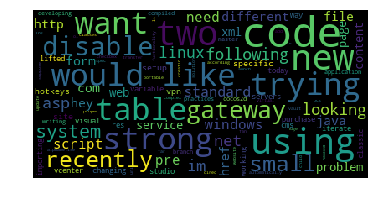

In [223]:
stopword_list = set(stopwords.words("english"))

word_cloud = WordCloud(
                          background_color='black',
                          stopwords=stopword_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(test_data.Body))
print(word_cloud)
fig = plt.figure(1)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
fig.savefig("test_word2.png", dpi=900)

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_df=0.8,stop_words=stopword_list, max_features=10000, ngram_range=(1,3))
tf_idf.fit(test_data.Body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"doesn't", 'herself', 'hadn', 'as', 'each', 'some', "mustn't", 'shouldn', 'his', 'off', 'most', 'not', 'few', 'isn', 'above', 'she', 'don', 'or', 'needn', 'o', "haven't", 'when', 'was', 'been', 'about', 'here', 'hasn', 'such', 'to', 'whom', "won't", 'will', 'theirs', 'who', 'while', 'onc...lf', 'in', 's', "couldn't", 'yourself', 'more', 'both', 'weren', 'i', 'we', 'why', 'doesn', "she's"},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [225]:
doc = pd.Series(test_data.Body[500])
doc_vector = tf_idf.transform(doc)

In [227]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(doc_vector.tocoo())
#extract only the top n; n here is 10
feature_names = tf_idf.get_feature_names()
test_keywords1=extract_topn_from_vector(feature_names,sorted_items,5)

In [228]:
print("Keywords in Body - test:")
print(doc[0][:10000])

Keywords in Body - test:
 p an interesting thought just occurred to me while thinking about ntfs    p      p ntfs supports hard links  symbolic links  and alternate data streams  is it possible for an ads to be a link to another file  conversely  do the alternate data streams attached to a link belong to the link itself or to the underlying filesystem data   p   


In [229]:
print("Keywords in Body - Test:")
for s in test_keywords1:
    print(s,test_keywords1[s])

Keywords in Body - Test:
streams 0.588
alternate 0.559
hard 0.482
data 0.331


In [230]:
print("Total keywords in the whole training data")
for k in keywords:
    print(k,keywords[k])
for m in keywords1:
    print(m,keywords1[m])
for n in keywords2:
    print(n,keywords2[n])

Total keywords in the whole training data
processing iphone 0.513
sax 0.476
streaming 0.421
processing 0.398
iphone 0.3
nsdata 0.419
parsing 0.359
stream 0.323
source 0.241
xml 0.24
xml cocoa 0.427
sax 0.427
iphone xml cocoa 0.427
iphone xml 0.403
streaming 0.338


In [231]:
print("Total keywords in the whole testing data")
for l in test_keywords:
    print(l,test_keywords[l])
for s in test_keywords1:
    print(s,test_keywords1[s])

Total keywords in the whole testing data
streams 0.588
alternate 0.559
hard 0.482
data 0.331
ntfs 0.435
alternate 0.425
link 0.354
links 0.296
data 0.265
